# Discretization API

## ⚠️ This notebook is work in progress

`jaxdf` revolves around the concept of discretization.

We will call **discretization family** the mapping $\mathcal{D}$ that associates a function $f$ to a set of discrete parameters $\theta$

$$
\theta \xrightarrow{\mathcal{D}}f
$$

with $f \in \text{Range}(\mathcal{D})$ or, in other words, $f_\theta(x) = \mathcal{D}(\theta, x)$ is a function parametrized by $\theta$.

$\theta$ is the **discrete representation** of $f$ over $\mathcal{D}$. The latter is analogous to the interpolation function defined in other libraries (See for example the [Operator Discretization Library](https://odl.readthedocs.io))

### Example

A simple example of discretization family is the set of $N$-th order polynomials on the interval $[0,1)$: 

$$
\mathcal{P}_N(\theta,x) = \sum_{i=0}^N \theta_i x^i, \qquad \theta \in \mathbb{R}^{N+1}
$$

In `jaxdf`, we construct such a field using the `Continuous` discretization. To do so, we have to provide the function $\mathcal{P}_N$, the parameters of the function and the domain where the function is defined

In [3]:
from jaxdf.discretization import Continuous
from jaxdf.geometry import Domain
from jax.random import normal, PRNGKey
from jax import numpy as jnp

seed = PRNGKey(30)
N = 5

from jaxdf.geometry import Domain
domain = Domain((16,),(2/16.,))

def p_n(theta, x):
    i = jnp.arange(N)
    powers = x**i
    return jnp.expand_dims(jnp.sum(theta*(x**i)), -1)

params = normal(seed, (N,))
print(p_n(params, 1.0))
domain = Domain((32,),(1/32.,))

u = Continuous(params, domain, p_n)

[-0.7961671]


Let's look at the field over the domain using the `on_grid` method

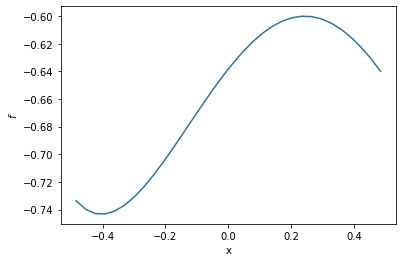

In [5]:
from matplotlib import pyplot as plt

def show_field(u, domain):
    plt.plot(domain.spatial_axis[0], u.on_grid)
    plt.xlabel("x")
    plt.ylabel("$f$")
    plt.show()
    
show_field(u, domain)

To get the field at a specific location $x$, we can use the `get_field` method, or simply call the field with the coordinates.

In [6]:
x = 1.2
print(f"Field at x={x} : {u(x)}")

Field at x=1.2 : [-0.6932602]


Fields are pytrees (thank you [equinox](https://github.com/patrick-kidger/equinox) for the inspiration!!), so they natively work `jax.jit`, `jax.grad` etc.

Let's try to apply derivative operator to this newly defined field

In [7]:
from jaxdf.operators import derivative

du_dx = derivative(u)

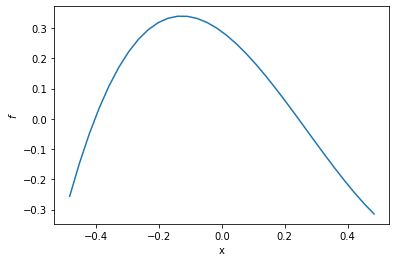

In [8]:
show_field(du_dx, domain)

The parameter of the field `du_dx` are the same as `u`, since for `Continuous` fields the `gradient` operator is evaluated using autograd, which is an operation that only affects the computational grah of a function but not its inputs

In [9]:
u.params, du_dx.params

(DeviceArray([-0.63833684,  0.28805315, -0.3826469 , -0.8146744 ,
               0.75143784], dtype=float32),
 DeviceArray([-0.63833684,  0.28805315, -0.3826469 , -0.8146744 ,
               0.75143784], dtype=float32))

## Customizing discretizations

For a polynomial field, we actually know analytically how to compute derivatives:

$$
\frac{\partial}{\partial x}\mathcal{P}_N(\theta,x) = \frac{\partial}{\partial x} \sum_{i=0}^N \theta_i x^i = \sum_{i=0}^{N-1} i\theta_{i+1} x^i
$$

To use this knowledge, we first define a new discretization family from the `Continuous` class, using the `@register_pytree_node_class` decorator lifted from [`jax.tree_util.register_pytree_node`](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.register_pytree_node.html).

This new class needs to initialize the parent class using the `super().__init__()` method; the input parameters are `params,domain,get_field`. The first one must be a `PyTree` compatible with `jax.numpy` (arrays, dictionaries of arrays, etc.); the `domain` attribute must be the `jaxdf.geometry.Domain` object defining the domain of the field. The last attribute, `get_field`, must be a function that evaluates the field at a coordinate using the parameters contained in `params`, and has the signature `get_fun(params: Field.params, x: Union[jnp.ndarray,float])`.

In [10]:
from jaxdf import register_pytree_node_class#

@register_pytree_node_class
class Polynomial(Continuous):
    @classmethod
    def from_params(cls, params, domain):
        def get_fun(params, x):
            i = jnp.arange(len(params))
            powers = x**i
            return jnp.expand_dims(jnp.sum(params*(x**i)), -1)
        return cls(params, domain, get_fun)

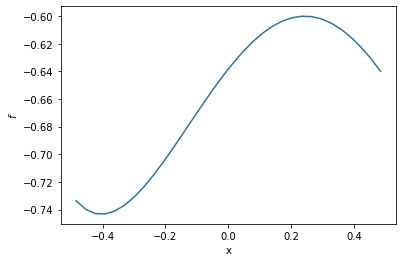

Field Polynomial [-0.63833684  0.28805315 -0.3826469  -0.8146744   0.75143784]


In [11]:
u_custom = Polynomial.from_params(u.params, u.domain)
show_field(u_custom, domain)
print(u_custom, u_custom.params)

To overload the `derivative` function, we have several options. One is to simply define a python function that generates the  `Polynomial` object resulting from the gradient computation.

In [12]:
def derivative(u: Polynomial):
    new_params = u.params[1:]*jnp.arange(1, u.params.shape[0])
    return Polynomial.from_params(new_params, u.domain)

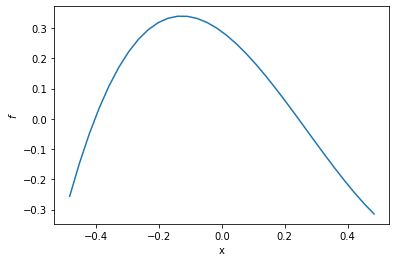

Field Polynomial [ 0.28805315 -0.7652938  -2.4440231   3.0057514 ] [0.08448768]


In [14]:
du_custom = derivative(u_custom)
show_field(du_custom, domain)
print(du_custom, du_custom.params, du_custom(1.0))

Note that the code is fully differentiable and can be compiled

In [15]:
import jax

@jax.jit
def f(u):
    x = derivative(u) + 0.3
    return x(0.1)

_ = f(u)
print(_)

[0.4900893]


However, note that now we have a derivative function defined for all types, and we get incorrect results for fields that are not Polynomials

[-0.71468043]


ValueError: x and y can be no greater than 2D, but have shapes (32,) and (32, 1, 1)

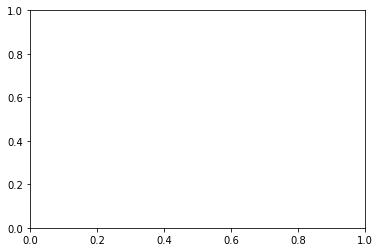

In [19]:
def sinfun(params, x):
    theta = jnp.sum(params) # dummy operation to make the parameter vector a scalar
    return jnp.expand_dims(jnp.sin(theta*x), -1)

params = u.params
print(sinfun(params, 1.0))
sin = Continuous(params, domain, sinfun)
show_field(sin, domain)

_ = f(sin)
print(_)

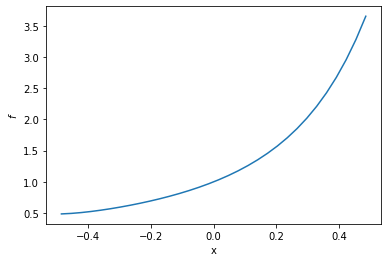

z:  Field Polynomial


In [16]:
z = derivative(sin)
show_field(z, domain)
print('z: ', z)

One way to avoid this is to implement the operators as methods of the fields, which are then redefined by the children classes. This was the approach used in `jaxdf` when it was made public, and it still can be used

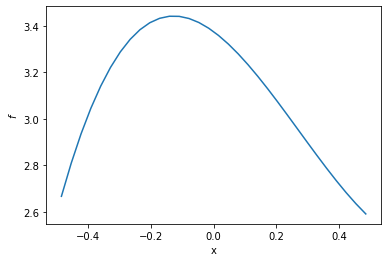

In [17]:
@register_pytree_node_class
class PolynomialWithMethods(Polynomial):
    
    @classmethod
    def from_params(cls, params, domain):
        def get_fun(params, x):
            i = jnp.arange(len(params))
            powers = x**i
            return jnp.expand_dims(jnp.sum(params*(x**i)), -1)
        return cls(params, domain, get_fun)
    
    # Custom derivative code, with parameters
    def derivative(self, exponent=1.0):
        new_params = self.params[1:]*jnp.arange(1, self.params.shape[0])*exponent
        return PolynomialWithMethods.from_params(new_params, self.domain)
    
@jax.jit
def g(u, exponent):
    return u.derivative(exponent) + 3.0

u_2 = PolynomialWithMethods.from_params(u.params, u.domain)
_ = g(u_2, 1.3)
show_field(_, domain)

However, it can become cumbersome to deal with many derived methods for different kind of discretizations, especially if one starts to evaluate operators that accept multiple operands with different combinations of discretizations. 

This problem elegantly resolved in some programming languages usign *multiple-dispatch*. One of the languages that notably supports multiple dispatch is the [Julia language](https://docs.julialang.org/en/v1/manual/methods/), and I suggest to look at the packages of the [Sci ML echosystem](https://sciml.ai/documentation/) if you are familiar with Julia and or interested in learning this language (those packages look great!).

For us sticking with python and `jaxdf`, here we borrow those ideas using the python multiple dispatch library [plum](https://github.com/wesselb/plum). The `jaxdf.operator` decorator can be used to define new (parametric) operators using as
```python
@operator
def new_operator(*args, **kwargs, params=1.0):
    ... # 
    return Field(...), params
```

The input of the fuction can be arbitrary types: if they are fields or any type which is traceable by jax, they will be traced. The function has a resved inpout keyword `params`, which is reserved for the parameters of the operator. The output of the function must me the resulting field and the default parameters.

The use of the `@operator` decorator makes sense when the arguments are defined using type annotation. In that way, we are using the dispatch method of `plum` to define an implementation of that function which is specific for the annotated types:

In [56]:
from jaxdf import operator

@operator
def derivative(x: Polynomial, axis=0, params=None):
    print('Applying derivative to a polynomial')
    get_x = x.aux['get_field']
    new_params = u.params[1:]*jnp.arange(1, u.params.shape[0])
    print(jax.eval_shape(get_x, x.params, 1.0))
    return Polynomial.from_params(new_params, u.domain), None

@operator
def derivative(x: Continuous, params=None):
    print('Applying derivative to a generic function')
    get_x = x.aux['get_field']
    def grad_fun(p, coords):
        f_jac = jax.jacfwd(get_x, argnums=(1,))
        return f_jac(p, coords)[0][0]
    
    print(jax.eval_shape(grad_fun, x.params, 1.0))
    print(jax.eval_shape(get_x, x.params, 1.0))
    return Continuous(x.params, x.domain, grad_fun), None

Applying derivative to a polynomial
ShapeDtypeStruct(shape=(1,), dtype=float32)


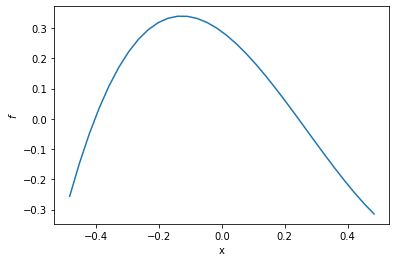

In [57]:
du_custom = derivative(u_custom)
show_field(du_custom, domain)

In [58]:
z = derivative(sin)
show_field(z, domain)
print('z: ', z)

Applying derivative to a generic function


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

Note again that the functions can be jitted and can apply autograd

In [52]:
derivative(sin)(1.0)

Applying derivative to a generic function
ShapeDtypeStruct(shape=(1,), dtype=float32)
ShapeDtypeStruct(shape=(1,), dtype=float32)


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [28]:
@jax.jit
def h(u):
    x = derivative(u)/7.
    return x(1.0)

print(h(u_custom))
print(h(sin))

Applying derivative to a polynomial
[0.01206967]
Applying derivative to a generic function


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [ ]:
@register_pytree_node_class
class Continuous(Field):
  def __init__(
    self,
    params,
    domain,
    get_fun=lambda p,x: None 
  ):
    aux = {"get_field": get_fun}
    x = domain.origin
    dims = eval_shape(get_fun, params, x).shape
    super().__init__(params, domain, dims, aux)
    
  def tree_flatten(self):
    children = (self.params,)
    aux_data = (self.dims, self.domain, self.aux["get_field"])
    return (children, aux_data)

  @classmethod
  def tree_unflatten(cls, aux_data, children):
    params = children[0]
    dims, domain, get_fun = aux_data
    a = cls(params, domain=domain, get_fun=get_fun)
    return a
  
  def replace_params(self, new_params):
    return self.__class__(new_params, self.domain, self.aux["get_field"])
  
  def update_fun_and_params(
    self,
    params,
    get_field
  ):
    return self.__class__(params, self.domain, get_field)

We want to solve the steady-state heat equation with boundary conditions

$$
u(-1) = 1, \qquad u(1) = 0
$$

We will use the [PINNs](https://www.sciencedirect.com/science/article/pii/S0021999118307125) approach to solve the equation, that is:

1. We generate a differentiable loss function that involves both the boundary conditions and the physics loss
2. Minimize the loss with gradient descent, with respect to the parameters of the input field

In [ ]:
import jax

sampler = domain.domain_sampler

def loss(u, seed):
    
    @jax.vmap
    def field_fun(x):
        return u.get_field(x)
    
    # Physics (domain) loss
    sample_points = sampler(seed, 128)
    phys_loss = jnp.mean(jnp.abs(field_fun(sample_points))**2)
    
    # Boundary loss
    left_val = u.get_field(-.5)[0]
    right_val = u.get_field(.5)[0]
    bound_loss = (jnp.abs(left_val - 1)**2 +  jnp.abs(right_val)**2)/2
    
    return phys_loss + bound_loss

In [ ]:
key, seed = jax.random.split(seed)
loss(u, seed)

In [ ]:
@jax.jit
def update(opt_state, seed, k):
    lossval, grads = jax.value_and_grad(loss)(get_params(opt_state), seed)
    return lossval, update_fun(k, grads, opt_state)

In [ ]:
from tqdm import tqdm
from jax.example_libraries import optimizers


# Setup optimizer
init_fun, update_fun, get_params = optimizers.adam(.0001)
opt_state = init_fun(u)

# Optimization loop
pbar = tqdm(range(100000))
rng = seed
for k in pbar:
    rng, seed = random.split(rng,2)
    lossval, opt_state = update(opt_state, seed, k)
    
    if k % 500 == 99:
        pbar.set_description(f"Loss: {lossval}")

In [ ]:
u_solution = get_params(opt_state)
show_field(u_solution, domain)

In [ ]:
u_solution.get_field(1)[0]

In [ ]:
u_solution.get_field(-1)[0]